In [1]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline
from IPython.display import display

import utilities as util

#FBProphet
from fbprophet import Prophet as proph

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#select smooth window size
window = 8

#read data and parameters for transformation
df, m, b, ref = util.read_data(csv_file = 'datahub/wti-daily_csv.csv', 
                              window = window)

df.head()

Time range: from 1986-01-02 00:00:00 to 2019-09-23 00:00:00


,Date,Price,y,y_smooth_w8
0,1986-01-02,25.56,0.612381,0.608235
1,1986-01-03,26.00,0.629227,0.625871
2,1986-01-06,26.53,0.649185,0.636625
3,1986-01-07,25.85,0.622999,0.640946
4,1986-01-08,25.87,0.623551,0.639284


Folder figs already exists.


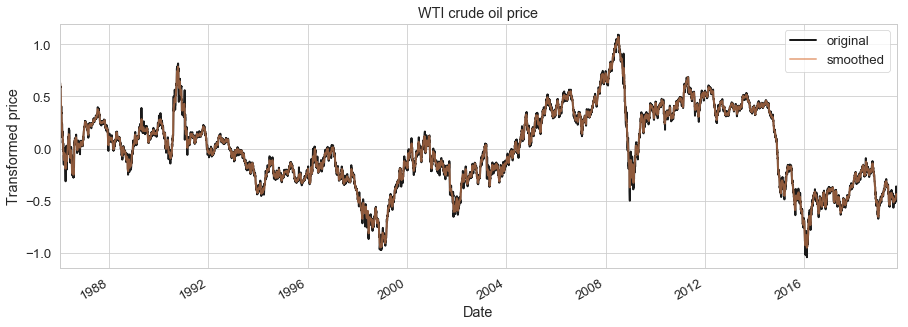

In [3]:
#plot transformed and smoothed values
fig, ax = plt.subplots(1,1,figsize=(15,5))
df.set_index('Date').y.plot(ax=ax,color='k',label='original', lw=2)
df.set_index('Date')[f'y_smooth_w{window}'].plot(ax=ax,color=sns.color_palette()[1],
                                                 label='smoothed',lw=2,alpha=0.6)

ax.set_ylabel('Transformed price')
ax.set_title('WTI crude oil price')
ax.legend()

#util.mkfolder('figs')
#plt.savefig('figs/WTI.png')
plt.show()

In [7]:
# function to do cross-validation for time-series
# using fbprophet for modeling

def post_process(df, df_metrics, df_true_pred, path):

    #inverse transform
    start_index = df.reset_index()[df.reset_index().Date == df_true_pred.index.min()].index[0]
    df_true_pred.y_true = util.inverse_transform(df_true_pred.y_true, m, b, ref, start_index).reshape(-1)
    df_true_pred.y_pred = util.inverse_transform(df_true_pred.y_pred, m, b, ref, start_index).reshape(-1)

    #plot
    fig = df_true_pred.plot(figsize=(12,6),lw=3,color=['k','r'])
    plt.legend(('True','Predicted'))
    plt.ylabel('Price ($)')
    plt.title(f'WTI crude oil price prediction using fbprophet for {n_outputs} days.')
    plt.savefig(f'{path}/compare.png')

    #compute actual metrics based on data in actual units ($), not log-transformed
    mape_actual = []
    rmse_actual = []

    for i in np.arange(0,len(df_true_pred),n_outputs):
        y_true = df_true_pred.y_true.iloc[i:i+n_outputs].values
        y_pred = df_true_pred.y_pred.iloc[i:i+n_outputs].values

        #compute metrics in actual not transformed values
        mape_actual.append(util.mape(y_true,y_pred))
        rmse_actual.append(np.sqrt(mean_squared_error(y_true,y_pred)))

    df_metrics_actual = pd.DataFrame(dict(MAPE=mape_actual, RMSE=rmse_actual))

    ###Metric summary###
    #Mean Average Percentage Error (MAPE) summary for CV=100
    #for actual values
    util.metric_summary(df_metrics_actual, column='MAPE', alpha=0.68, 
                        model_name = 'fbprophet',figname='MAPE', folder=path)
    #for transformed
    util.metric_summary(df_metrics, column='MAPE', alpha=0.68, 
                        model_name = 'fbprophet',figname='MAPE_tf', folder=path)

    
    #Root Mean Square Error (RMSE) summary for CV=100
    #for actual values
    util.metric_summary(df_metrics_actual, column='RMSE', alpha=0.68, 
                        model_name = 'fbprophet',figname='RMSE', folder=path)
    #for transformed
    util.metric_summary(df_metrics, column='RMSE', alpha=0.68, 
                        model_name = 'fbprophet',figname='RMSE_tf', folder=path)


    #save df with metrics and summary:
    df_metrics_actual.to_csv(f'{path}/metrics.csv',index=False)
    df_metrics.to_csv(f'{path}/metrics_transformed.csv',index=False)
    #save true and predicted values in actual units ($)
    df_true_pred.to_csv(f'{path}/results/y_true_y_pred.csv',index=True)
    
    return df_metrics, df_true_pred

def fbprop_cv(df, target, cv_num, n_inputs, n_outputs, path):
    """Do slide window cross-validation
    with fbprophet using smooted (window) data to train 
    but compute test score on actual data"""
    
    #make necessary folders    
    util.mkfolder(path)
    
    #save results to the folder
    path_res = f'/{target}_train_{n_inputs}_test_{n_outputs}_cv_{cv_num}'
    path += path_res

    util.mkfolder(path)
    util.mkfolder(path + '/results/')
    util.mkfolder(path + '/components/')

    ################################################
    #smooth training data
    df_fbp = pd.DataFrame({'ds': df.Date,'y': df[target]})
    #select slices
    x, _ = util.sliding_windows(df_fbp.set_index('ds').y, 
                n_inputs = n_inputs, n_outputs = n_outputs) 

    #actual test data
    df_fbp = pd.DataFrame({'ds': df.Date,'y': df.y})
    #select slices
    _, y = util.sliding_windows(df_fbp.set_index('ds').y, 
                n_inputs = n_inputs, n_outputs = n_outputs)

    df_metrics = pd.DataFrame()
    df_true_pred = pd.DataFrame()

    #print CV parameters
    print(f'Use {n_inputs} points to predict {n_outputs}.')

    #select cv_num slices from the tail
    _ind = len(x)-cv_num
    img = _ind

    for X, Y in zip(x[_ind:],y[_ind:]):

        #initialize the prophet model
        m = proph(interval_width=0.95, yearly_seasonality=True, 
                  weekly_seasonality=False, daily_seasonality = False, 
                  changepoint_prior_scale=10) 
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=1)

        #fit the model
        m.fit(X.reset_index())

        #select dates to predict
        future = pd.DataFrame({'ds': list(X.index) + list(Y.index)})
        forecast = m.predict(future)
        #write metrics to dataframe
        df_metrics = df_metrics.append(util.metric_df(Y, forecast.yhat[n_inputs:]),
                                     ignore_index=True)
        
        #save Y_true and y_pred
        df_true_pred = df_true_pred.append(pd.concat([Y, 
                       forecast.set_index('ds').yhat.iloc[n_inputs:]],axis=1))

        #plot predictions:
        fig, ax = plt.subplots(1,1,figsize=(12,6))
        m.plot(forecast, ax=ax)
        Y.plot(marker='o', lw=0, markersize=3, 
               color='g', label='test', ax = ax)

        fs = 14
        ax.set_ylabel('Transformed price',fontsize=fs)
        ax.set_xlabel('Date',fontsize=fs)    
        ax.legend(('train','prediction','test','95% confidence'),loc='upper left',fontsize=fs)
        ax.set_title(f"WTI crude oil price prediction using fbprophet.",fontsize=fs)
        ax.set_ylim(-1,1.1) 

        plt.tight_layout()
        plt.savefig(f"{path}/results/prediction_slice{img}.png")

        #show only first plot
        if img == _ind:
            plt.show()
        else:
            plt.close(fig)

        #plot components:
        fig2 = m.plot_components(forecast)
        plt.savefig(f"{path}/components/components_slice{img}.png")
        plt.close(fig2)
        #display(df_metric.dropna())

        #slice completed, show every 10th
        slice_num = img - _ind + 1
        if slice_num % 10 == 0:
            print(f'Done with slice number {slice_num} out of {cv_num}.')
        img += 1

    #save df with metrics metric with log-transformed data
    df_true_pred.columns = ['y_true','y_pred']
    
    #do inverse transform: from log-tarnsformed and leveled data to actual ($)
    df_metrics, df_true_pred = post_process(df, df_metrics, df_true_pred, path)
   
    return df_metrics, df_true_pred

Folder CV_fbprophet already exists.
Use 506 points to predict 22.


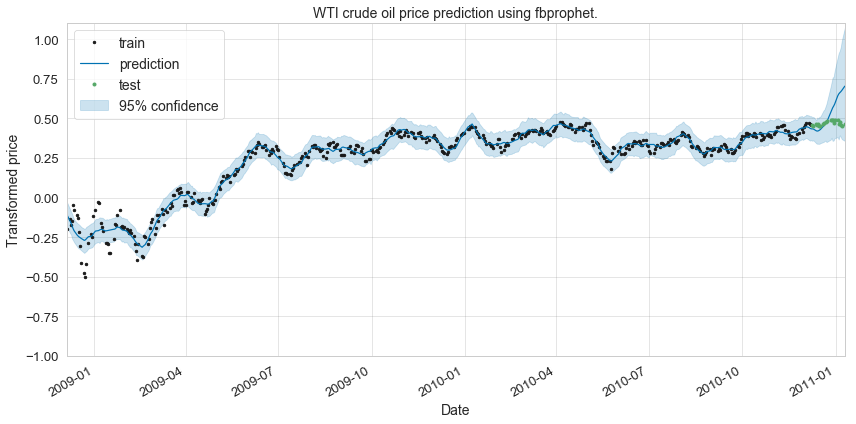

Done with slice number 10 out of 100.
Done with slice number 20 out of 100.
Done with slice number 30 out of 100.
Done with slice number 40 out of 100.
Done with slice number 50 out of 100.
Done with slice number 60 out of 100.
Done with slice number 70 out of 100.
Done with slice number 80 out of 100.
Done with slice number 90 out of 100.
Done with slice number 100 out of 100.


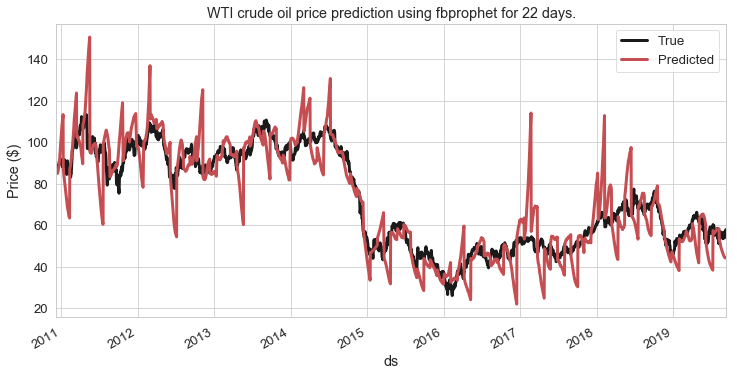

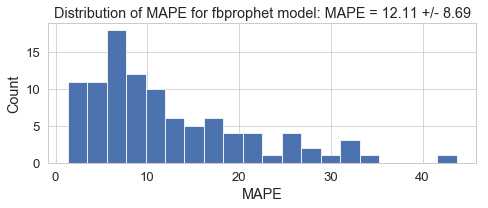

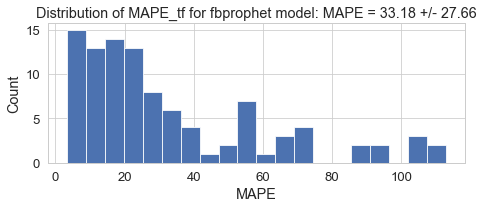

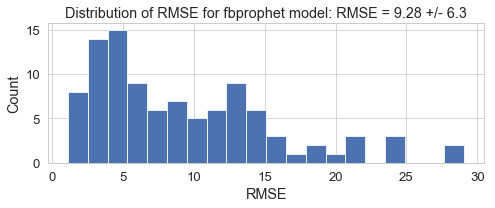

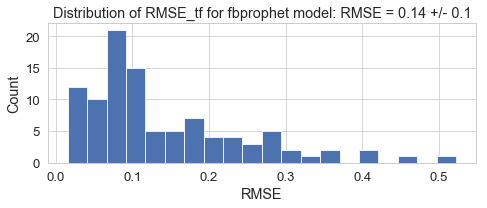

In [9]:
######################################################
##############CV and window optimization##############
######################################################
#Here two years of train data is used to predict 1 month ahead.

#number of CV slices
cv_num = 100
#253 trading days per year
n_inputs = 253 * 2
#22 B_days per month
n_outputs = 22

target = 'y' #f'y_smooth_w{window}'
#choose folder name to save results
path = 'CV_fbprophet'

#run CV
df_metrics, df_true_pred = fbprop_cv(df, target, cv_num, n_inputs, n_outputs, path)

Folder CV_fbprophet already exists.
Use 506 points to predict 22.


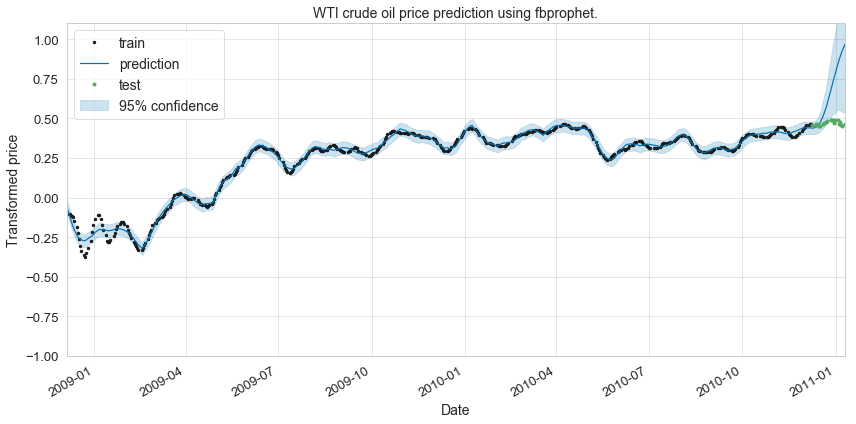

Done with slice number 10 out of 100.
Done with slice number 20 out of 100.
Done with slice number 30 out of 100.
Done with slice number 40 out of 100.
Done with slice number 50 out of 100.
Done with slice number 60 out of 100.
Done with slice number 70 out of 100.
Done with slice number 80 out of 100.
Done with slice number 90 out of 100.
Done with slice number 100 out of 100.


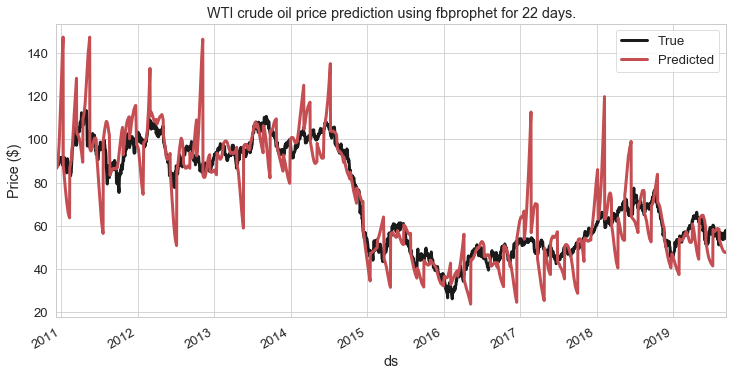

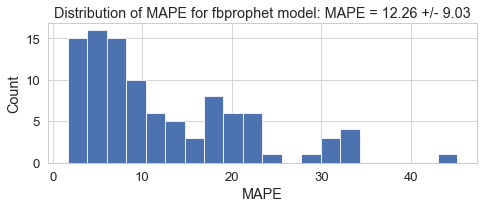

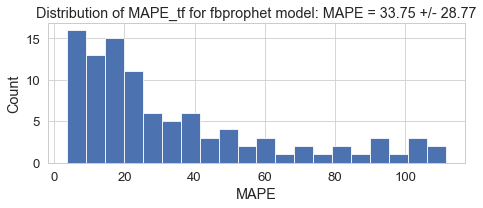

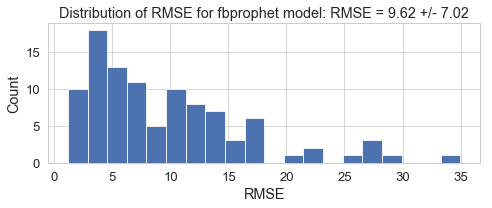

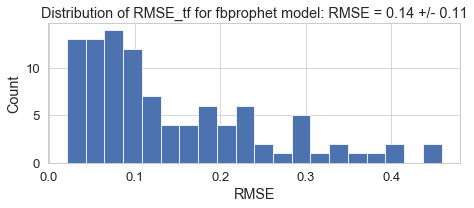

In [10]:
#calculate predictions for 22 days ahead and smooth target
n_outputs = 22
target = f'y_smooth_w{window}'
#run CV
df_metrics, df_true_pred = fbprop_cv(df, target, cv_num, n_inputs, n_outputs, path)

Folder CV_fbprophet already exists.
Use 506 points to predict 5.


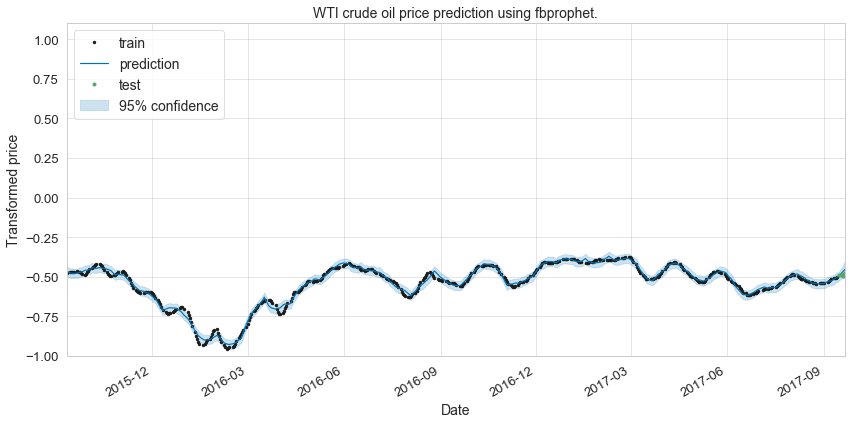

Done with slice number 10 out of 100.
Done with slice number 20 out of 100.
Done with slice number 30 out of 100.
Done with slice number 40 out of 100.
Done with slice number 50 out of 100.
Done with slice number 60 out of 100.
Done with slice number 70 out of 100.
Done with slice number 80 out of 100.
Done with slice number 90 out of 100.
Done with slice number 100 out of 100.


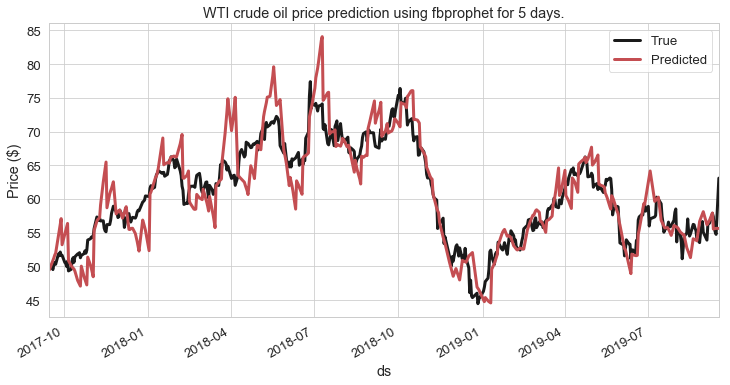

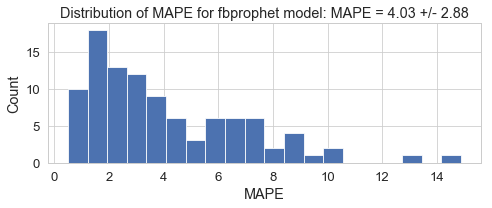

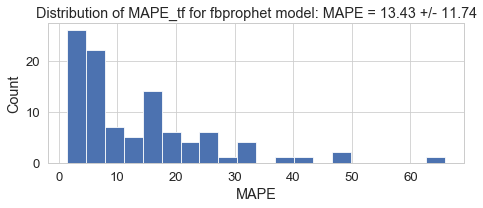

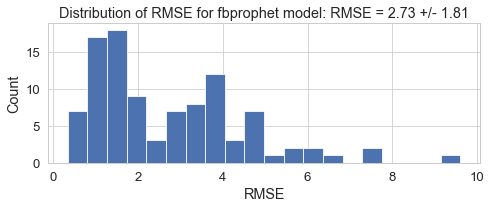

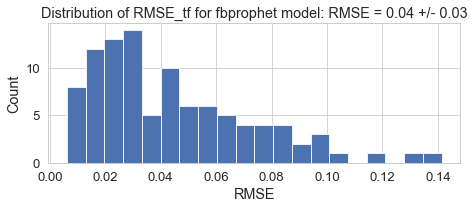

In [11]:
#calculate predictions for 22 days ahead and smooth target
n_outputs = 5

#run CV
df_metrics, df_true_pred = fbprop_cv(df, target, cv_num, n_inputs, n_outputs, path)